# Sparkify Project Workspace

In [1]:
# 1. load and clean data

# 2. Exploratory Data Analysis
    # When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.
    # Define Churn
    # Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.
    # Explore Data
    # Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# 3. Feature Engineering
    #  Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
    #  Write a script to extract the necessary features from the smaller subset of data
    #  Ensure that your script is scalable, using the best practices discussed in Lesson 3
    #  Try your script on the full data set, debugging your script if necessary
    #  If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# 4. Modeling
    #Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

In [4]:
# check
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '33837'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1677742114342'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '9ead5552b263'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
spark

# Load and Clean Dataset

In [6]:
# read json
path = 'mini_sparkify_event_data.json'
user_log = spark.read.json(path)

In [7]:
# check columns
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df1 = user_log.toPandas()

In [9]:
df1.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [10]:
df1.shape

(286500, 18)

In [11]:
df1.nunique()

artist            17655
auth                  4
firstName           189
gender                2
itemInSession      1322
lastName            173
length            14865
level                 2
location            114
method                2
page                 22
registration        225
sessionId          2354
song              58480
status                3
ts               277447
userAgent            56
userId              226
dtype: int64

In [12]:
df1.drop_duplicates()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [13]:
df1.shape

(286500, 18)

In [14]:
df1 = df1[df1.userId != '']

there are empty values for userId, i decided to remove all rows with empty userId, it is hard to understand how many people are not signed up. 

In [15]:
df1.isnull().sum()

artist           50046
auth                 0
firstName            0
gender               0
itemInSession        0
lastName             0
length           50046
level                0
location             0
method               0
page                 0
registration         0
sessionId            0
song             50046
status               0
ts                   0
userAgent            0
userId               0
dtype: int64

In [16]:
df1.head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis

In [17]:
columns = ['auth', 'gender', 'level', 'method', 'page', 'status']
for col in columns:
    unique = df1[f'{col}'].unique()
    print(f'unique values for {col} are {unique}')

unique values for auth are ['Logged In' 'Cancelled']
unique values for gender are ['M' 'F']
unique values for level are ['paid' 'free']
unique values for method are ['PUT' 'GET']
unique values for page are ['NextSong' 'Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade'
 'Thumbs Down' 'Home' 'Logout' 'Help' 'Upgrade' 'Add Friend' 'Settings'
 'Submit Upgrade' 'About' 'Submit Downgrade' 'Error' 'Save Settings'
 'Cancel' 'Cancellation Confirmation']
unique values for status are [200 307 404]


In [8]:
user_log.createOrReplaceTempView("user_log_table")

Defining churn as 'Cancellation Confirmation' event

In [9]:
churn = spark.sql('''
          SELECT userId, count(page) as churn
          FROM user_log_table
          WHERE page = 'Cancellation Confirmation'
          GROUP BY userId, level
          ORDER BY userId ASC
          '''
          )

In [10]:
# choose uerId column without '' empty strings. Later i will left join other created tables to following table:
table = spark.sql('''
          SELECT DISTINCT userId
          FROM user_log_table
          WHERE userId != ''
          ORDER BY userId ASC
          
          '''
          )

In [11]:
gender = spark.sql('''
          SELECT userId, gender
          FROM user_log_table
          GROUP BY userId, gender
          ORDER BY userId ASC
          '''
          )

In [12]:
songs = spark.sql('''
          SELECT userId, count(song) as songs
          FROM user_log_table
          GROUP BY userId
          ORDER BY userId ASC
          '''
          )

In [13]:
sessions = spark.sql('''
          SELECT userId, count(distinct(sessionId)) as sessions
          FROM user_log_table
          GROUP BY userId
          ORDER BY userId ASC
          '''
          )

In [14]:
playlist = spark.sql('''
          SELECT userId, count(page) as playlists
          FROM user_log_table
          WHERE page = 'Add to Playlist'
          GROUP BY userId
          ORDER BY userId ASC
          '''
          )

In [15]:
thumbsup = spark.sql('''
          SELECT userId, count(page) as ups
          FROM user_log_table
          WHERE page = 'Thumbs Up'
          GROUP BY userId
          ORDER BY userId ASC
          '''
          )

In [16]:
level = spark.sql('''
          SELECT userId, LAST(level) as subscription_type
          FROM user_log_table
          GROUP BY userId
          ORDER BY userId ASC
          '''
          )


In [17]:
ThumbsDown = spark.sql('''
          SELECT userId, count(page) as ThumbsDown
          FROM user_log_table
          WHERE page = 'Thumbs Down'
          GROUP BY userId
          ORDER BY userId ASC
          '''
          )

In [18]:
Help = spark.sql('''
          SELECT userId, count(page) as Help
          FROM user_log_table
          WHERE page = 'Help'
          GROUP BY userId
          ORDER BY userId ASC
          '''
          )

In [19]:
Upgrade = spark.sql('''
          SELECT userId, count(page) as Upgrade
          FROM user_log_table
          WHERE page = 'Submit Upgrade'
          GROUP BY userId
          ORDER BY userId ASC
          '''
          )

In [20]:
AddFriend = spark.sql('''
          SELECT userId, count(page) as AddFriend
          FROM user_log_table
          WHERE page = 'Add Friend'
          GROUP BY userId
          ORDER BY userId ASC
          '''
          )

In [21]:
Error = spark.sql('''
          SELECT userId, count(page) as Error
          FROM user_log_table
          WHERE page = 'Error'
          GROUP BY userId
          ORDER BY userId ASC
          '''
          )

In [22]:
# make all of these separate tables dataframes 
items = [table, gender, level, songs, sessions, playlist, thumbsup, ThumbsDown, Help, Upgrade, AddFriend, Error, churn]

for item in items:
    print(item)
    item = item.toPandas()
    


DataFrame[userId: string]
DataFrame[userId: string, gender: string]
DataFrame[userId: string, subscription_type: string]
DataFrame[userId: string, songs: bigint]
DataFrame[userId: string, sessions: bigint]
DataFrame[userId: string, playlists: bigint]
DataFrame[userId: string, ups: bigint]
DataFrame[userId: string, ThumbsDown: bigint]
DataFrame[userId: string, Help: bigint]
DataFrame[userId: string, Upgrade: bigint]
DataFrame[userId: string, AddFriend: bigint]
DataFrame[userId: string, Error: bigint]
DataFrame[userId: string, churn: bigint]


In [23]:
# unite all tables
for item in items[1:]:
    print(item)
    items[0] = items[0].join(item , on=['userId'] , how = 'left')


DataFrame[userId: string, gender: string]
DataFrame[userId: string, subscription_type: string]
DataFrame[userId: string, songs: bigint]
DataFrame[userId: string, sessions: bigint]
DataFrame[userId: string, playlists: bigint]
DataFrame[userId: string, ups: bigint]
DataFrame[userId: string, ThumbsDown: bigint]
DataFrame[userId: string, Help: bigint]
DataFrame[userId: string, Upgrade: bigint]
DataFrame[userId: string, AddFriend: bigint]
DataFrame[userId: string, Error: bigint]
DataFrame[userId: string, churn: bigint]


In [24]:
df = items[0]

In [25]:
# all nan values to 0
df = df.fillna(value=0)

In [26]:
# check for null values
from pyspark.sql.functions import when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
userId,0
gender,0
subscription_type,0
songs,0
sessions,0
playlists,0
ups,0
ThumbsDown,0
Help,0
Upgrade,0


In [27]:
# we got following table
df.show(3)

+------+------+-----------------+-----+--------+---------+---+----------+----+-------+---------+-----+-----+
|userId|gender|subscription_type|songs|sessions|playlists|ups|ThumbsDown|Help|Upgrade|AddFriend|Error|churn|
+------+------+-----------------+-----+--------+---------+---+----------+----+-------+---------+-----+-----+
|100010|     F|             free|  275|       7|        7| 17|         5|   2|      0|        4|    0|    0|
|200002|     M|             paid|  387|       6|        8| 21|         6|   2|      1|        4|    0|    0|
|   125|     M|             free|    8|       1|        0|  0|         0|   0|      0|        0|    0|    1|
+------+------+-----------------+-----+--------+---------+---+----------+----+-------+---------+-----+-----+
only showing top 3 rows



since we created final table, lets explore it

In [28]:
numeric_features = [songs, sessions, playlist, thumbsup, ThumbsDown, Help, Upgrade, AddFriend, Error, churn]

In [29]:
df2 = df.toPandas()

In [30]:
df2.head(5)

,userId,gender,subscription_type,songs,sessions,playlists,ups,ThumbsDown,Help,Upgrade,AddFriend,Error,churn
0,100010,F,free,275,7,7,17,5,2,0,4,0,0
1,200002,M,paid,387,6,8,21,6,2,1,4,0,0
2,125,M,free,8,1,0,0,0,0,0,0,0,1
3,124,F,paid,4079,29,118,171,41,23,0,74,6,0
4,51,M,paid,2111,10,52,100,21,12,0,28,1,1


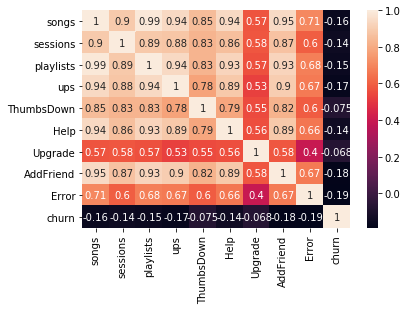

In [31]:
corr_matrix = df2.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

Plots:
    how many men and women churned and didnt churn, paid or free subscriptions
    what is average amount of sessions for churn and not churn and same for other columns

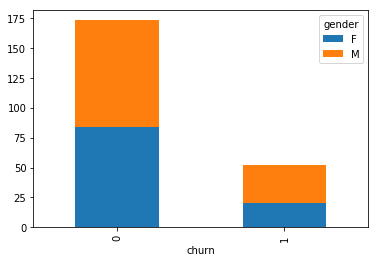

In [42]:
#how many men and women churned and didnt churn,
df2.groupby(["churn", "gender"]).size().unstack().plot(kind='bar',stacked=True)
plt.show()

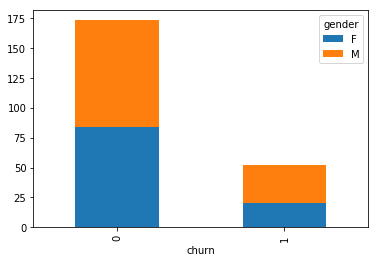

In [43]:
df2.groupby(["churn", "gender"]).size().unstack().plot(kind='bar',stacked=True)
plt.show()

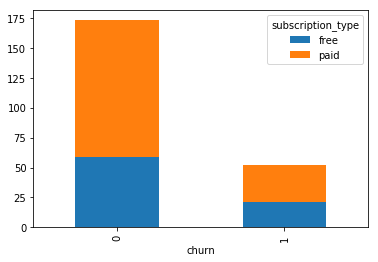

In [44]:
# paid or free subscriptions 
df2.groupby(["churn", "subscription_type"]).size().unstack().plot(kind='bar',stacked=True)
plt.show()

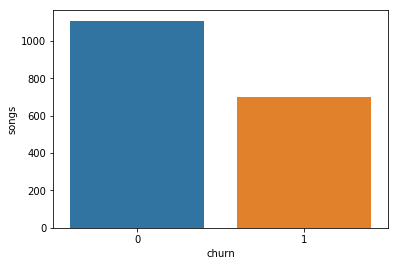

In [45]:
import seaborn as sns
df2.groupby('churn', as_index=False)['songs'].mean()
# plot
p = sns.barplot('churn', 'songs', data=df2, ci=False)

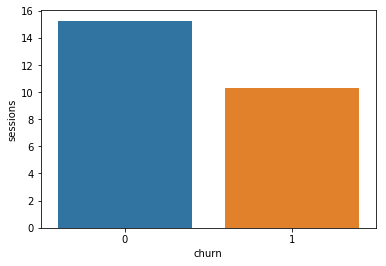

In [46]:
df2.groupby('churn', as_index=False)['sessions'].mean()
# plot
p = sns.barplot('churn', 'sessions', data=df2, ci=False)

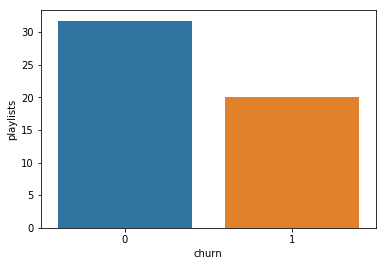

In [47]:
df2.groupby('churn', as_index=False)['playlists'].mean()
# plot
p = sns.barplot('churn', 'playlists', data=df2, ci=False)

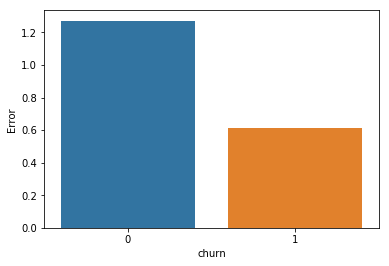

In [48]:
df2.groupby('churn', as_index=False)['Error'].mean()
# plot
p = sns.barplot('churn', 'Error', data=df2, ci=False)

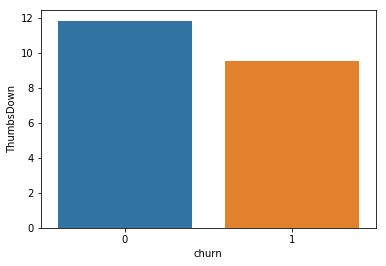

In [49]:
df2.groupby('churn', as_index=False)['ThumbsDown'].mean()
# plot
p = sns.barplot('churn', 'ThumbsDown', data=df2, ci=False)

# Feature Engineering

we have created table, but we need to prepare it for modelling. we will prepare two columns - one is vector column of all values we have, and the other is our target prediction value - churn column. 
To create vector column we will change categorical data into numbers and then vectorize all values.

In [32]:
feature_Cols = df.columns
numeric_Cols = feature_Cols[3:-1]
print(numeric_Cols)

['songs', 'sessions', 'playlists', 'ups', 'ThumbsDown', 'Help', 'Upgrade', 'AddFriend', 'Error']


In [33]:
categCols = ['gender', 'subscription_type']

In [34]:
stages = []

In [35]:
# prep of calegorical data
for categCol in categCols:
    stringIndexer = StringIndexer(inputCol = categCol, outputCol = categCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categCol + "classVec"])
    stages += [stringIndexer, encoder] 

In [36]:
# vectorize
StringIndex_churn = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [StringIndex_churn]

assem_Inp = [c + "classVec" for c in categCols] + numeric_Cols
assembler = VectorAssembler(inputCols=assem_Inp, outputCol="features")
stages += [assembler]

In [37]:
# create feature column and output (churn) column:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

In [38]:
df.show(3)

+------+------+-----------------+-----+--------+---------+---+----------+----+-------+---------+-----+-----+-----------+--------------+----------------------+-------------------------+-----+--------------------+
|userId|gender|subscription_type|songs|sessions|playlists|ups|ThumbsDown|Help|Upgrade|AddFriend|Error|churn|genderIndex|genderclassVec|subscription_typeIndex|subscription_typeclassVec|label|            features|
+------+------+-----------------+-----+--------+---------+---+----------+----+-------+---------+-----+-----+-----------+--------------+----------------------+-------------------------+-----+--------------------+
|100010|     F|             free|  275|       7|        7| 17|         5|   2|      0|        4|    0|    0|        1.0|     (1,[],[])|                   1.0|                (1,[],[])|  0.0|[0.0,0.0,275.0,7....|
|200002|     M|             paid|  387|       6|        8| 21|         6|   2|      1|        4|    0|    0|        0.0| (1,[0],[1.0])|                 

In [39]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
userId,100010,200002,125,124,51
gender,F,M,M,F,M
subscription_type,free,paid,free,paid,paid
songs,275,387,8,4079,2111
sessions,7,6,1,29,10
playlists,7,8,0,118,52
ups,17,21,0,171,100
ThumbsDown,5,6,0,41,21
Help,2,2,0,23,12
Upgrade,0,1,0,0,0


In [40]:
df.drop(df.userId)

DataFrame[gender: string, subscription_type: string, songs: bigint, sessions: bigint, playlists: bigint, ups: bigint, ThumbsDown: bigint, Help: bigint, Upgrade: bigint, AddFriend: bigint, Error: bigint, churn: bigint, genderIndex: double, genderclassVec: vector, subscription_typeIndex: double, subscription_typeclassVec: vector, label: double, features: vector]

In [41]:
df.show(1)

+------+------+-----------------+-----+--------+---------+---+----------+----+-------+---------+-----+-----+-----------+--------------+----------------------+-------------------------+-----+--------------------+
|userId|gender|subscription_type|songs|sessions|playlists|ups|ThumbsDown|Help|Upgrade|AddFriend|Error|churn|genderIndex|genderclassVec|subscription_typeIndex|subscription_typeclassVec|label|            features|
+------+------+-----------------+-----+--------+---------+---+----------+----+-------+---------+-----+-----+-----------+--------------+----------------------+-------------------------+-----+--------------------+
|100010|     F|             free|  275|       7|        7| 17|         5|   2|      0|        4|    0|    0|        1.0|     (1,[],[])|                   1.0|                (1,[],[])|  0.0|[0.0,0.0,275.0,7....|
+------+------+-----------------+-----+--------+---------+---+----------+----+-------+---------+-----+-----+-----------+--------------+-----------------

In [42]:
# leaving only vector and output columns
dataframe = df.select('features', 'label')

In [43]:
dataframe.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,275.0,7....|  0.0|
|[1.0,1.0,387.0,6....|  0.0|
|(11,[0,2,3],[1.0,...|  1.0|
|[0.0,1.0,4079.0,2...|  0.0|
|[1.0,1.0,2111.0,1...|  1.0|
+--------------------+-----+
only showing top 5 rows



# Modelling

In [44]:
# split df to test and train data
train, test = dataframe.randomSplit([0.7, 0.3], seed=0)
print("Train: " + str(train.count()))
print("Test: " + str(test.count()))

Train: 155
Test: 70


In [45]:
train, test

(DataFrame[features: vector, label: double],
 DataFrame[features: vector, label: double])

In [46]:
models = []

In [47]:
F1_scores = []

In [48]:
print('ok')

ok


Our data is ready for modelling

try different ml models and evaluate them using f1 score, choose best one

In [49]:
from pyspark.mllib.evaluation import MulticlassMetrics

def f1_of_model(model_name, predictions, models):
    ''' 
    input: predictions and name of model
    output: f1 score of model
    '''
    res = predictions.select(['prediction', 'label'])
    pl=res.rdd
    metrics = MulticlassMetrics(pl)
    con_matrix=metrics.confusionMatrix().toArray()
    accuracy=(con_matrix[0][0]+con_matrix[1][1])/con_matrix.sum()
    precision=(con_matrix[0][0])/(con_matrix[0][0]+con_matrix[1][0])
    recall=(con_matrix[0][0])/(con_matrix[0][0]+con_matrix[0][1])
    F1 = 2*(recall * precision) / (recall + precision)
    models.append(model_name)
    F1_scores.append(F1)
    print(f'F1 for {model_name} is {F1}')

In [50]:
print('finish')

finish


In [51]:
evaluator = MulticlassClassificationEvaluator(labelCol='label')

In [52]:
numFolds = 3

# logistic regression

In [53]:
lr = LogisticRegression(maxIter=10, labelCol='label', featuresCol='features')

evaluator = MulticlassClassificationEvaluator(labelCol='label')

paramGrid = (ParamGridBuilder()
                .addGrid(lr.elasticNetParam, [0, 1])
                .build())

cv_model = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=numFolds)

lr_model = cv_model.fit(train)

lr_predictions = lr_model.transform(test)

In [54]:
print('done')

done


In [56]:
print(evaluator.evaluate(lr_predictions, {evaluator.metricName : 'f1'}))

0.7437570303712036


In [57]:
lr_model.getEstimatorParamMaps()[ np.argmax(lr_model.avgMetrics) ]

{Param(parent='LogisticRegression_c39bbc47c3bb', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}

# Decision Tree

In [58]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

paramGrid = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [2, 5, 10, 20])
                .build())

cv_model = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=numFolds)

dt_model = cv_model.fit(train)

dt_predictions = dt_model.transform(test)

In [60]:
dt_model.getEstimatorParamMaps()[ np.argmax(dt_model.avgMetrics) ]

{Param(parent='DecisionTreeClassifier_16b20358c5e6', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2}

In [61]:
print(evaluator.evaluate(dt_predictions, {evaluator.metricName : 'f1'}))

0.7437570303712036


In [79]:
print(evaluator.evaluate(dt_predictions, {evaluator.metricName : 'accuracy'}))

0.8142857142857143


# Random Forest

In [62]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')


paramGrid = (ParamGridBuilder()
                .addGrid(rf.numTrees, [5, 20, 50])
                .build())

cv_model = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=numFolds)

rf_model = cv_model.fit(train)

rf_predictions = rf_model.transform(test)

In [65]:
print(evaluator.evaluate(rf_predictions, {evaluator.metricName : 'f1'}))

0.7437570303712036


In [80]:
print(evaluator.evaluate(rf_predictions, {evaluator.metricName : 'accuracy'}))

0.8142857142857143


In [66]:
rf_model.getEstimatorParamMaps()[ np.argmax(rf_model.avgMetrics) ]

{Param(parent='RandomForestClassifier_37f567fbd748', name='numTrees', doc='Number of trees to train (>= 1).'): 5}

# Gradient-Boosted Tree Classifier

In [67]:
gbt = GBTClassifier(maxIter=10)

paramGrid = (ParamGridBuilder()
                .addGrid(gbt.maxIter, [10, 20])
                .build())

cv_model = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=numFolds)

gbt_model = cv_model.fit(train)

gbt_predictions = gbt_model.transform(test)



In [77]:
gbt_model.getEstimatorParamMaps()[ np.argmax(gbt_model.avgMetrics) ]

{Param(parent='GBTClassifier_c0f1cbf57ed7', name='maxIter', doc='max number of iterations (>= 0).'): 20}

In [70]:
print(evaluator.evaluate(gbt_predictions, {evaluator.metricName : 'f1'}))

0.6853209720466358


<Container object of 4 artists>

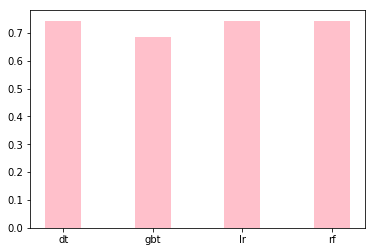

In [76]:
models = ['lr', 'dt', 'rf', 'gbt']
results = [0.7437570303712036, 0.7437570303712036, 0.7437570303712036, 0.6853209720466358]

plt.bar(models, results, color ='pink',
        width = 0.4)


In [ ]:
print('finish')